<a href="https://colab.research.google.com/github/zrd123/my_colab/blob/master/code/linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 线性回归

In [ ]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [ ]:
# 创建一个数据集
def synthetic_data(w, b, num_examples):
  # 均值为0,方差为1,有n个样本，列长为len(w)
  X = torch.normal(0, 1, (num_examples, len(w)))
  # 获取函数：y = X*w + b
  y = torch.matmul(X, w) + b
  #生成随机噪音
  y += torch.normal(0, 0.01, y.shape)
  return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [ ]:
print("features:", features[0], "\nlabel:", labels[0])

features: tensor([ 0.5740, -1.1890]) 
label: tensor([9.3872])


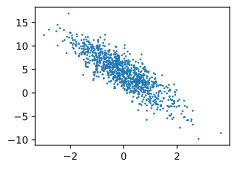

In [ ]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),
                labels.detach().numpy(), 1)

In [ ]:
# 生成小批量
def data_iter(batch_size, features, labels):
  num_examples = len(features)
  indices = list(range(num_examples))
  # 随机读取样本
  random.shuffle(indices)
  for i in range(0, num_examples, batch_size):
    batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
    yield features[batch_indices], labels[batch_indices]

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
  print(X, '\n', y)
  break;

tensor([[-1.0635, -1.2628],
        [-0.8587,  0.3884],
        [ 1.3100, -3.0241],
        [ 0.1326, -1.5312],
        [ 0.4072, -0.8891],
        [ 0.1587,  0.3262],
        [ 0.2476, -1.2064],
        [ 0.2855, -0.4543],
        [ 0.4749, -0.1397],
        [-0.0505,  0.5877]]) 
 tensor([[ 6.3616],
        [ 1.1401],
        [17.1104],
        [ 9.6660],
        [ 8.0314],
        [ 3.3898],
        [ 8.7756],
        [ 6.3208],
        [ 5.6257],
        [ 2.0974]])


In [ ]:
# 定义模型
def linreg(X, w, b):
  return torch.matmul(X, w) + b

w = torch.normal(0, 0.01, size = (2,1), requires_grad = True)
b = torch.zeros(1, requires_grad = True)

In [ ]:
# 定义损失函数
def squared_loss(y_hat, y):
  """均方损失"""
  return (y_hat - y.reshape(y_hat.shape))**2 / 2

# 定义优化算法
#  list类型参数，包含w,b. lr学习率.
def sgd(params, lr, batch_size):
  """小批量随机梯度下降"""
  with torch.no_grad():
    for param in params:
      param -= lr * param.grad / batch_size
      param.grad.zero_()

In [ ]:
lr = 0.001
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
  for X, y in data_iter(batch_size, features, labels):
    # X和y的小批量损失-->(batch_size, 1)
    l = loss(net(X, w, b), y)
    # 计算[w，b]梯度
    l.sum().backward()
    sgd([w,b], lr, batch_size)
  with torch.no_grad():
    train_l = loss(net(features, w, b), labels)
    print(f"epoch {epoch + 1}, loss{float(train_l.mean()):f}")


epoch 1, loss0.000053
epoch 2, loss0.000053
epoch 3, loss0.000053


In [ ]:
print(f"w loss: {true_w - w.reshape(true_w.shape)}")
print(f"b loss: {true_b -b}")

w loss: tensor([-0.0004, -0.0003], grad_fn=<SubBackward0>)
b loss: tensor([0.0002], grad_fn=<RsubBackward1>)


# 简洁实现

In [ ]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

In [ ]:
def load_array(data_arrays, batch_size, is_train = True):
  """构造一个PyTorch数据迭代器"""
  dataset = data.TensorDataset(*data_arrays)
  return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-0.2986, -0.5610],
         [ 0.5202,  0.4751],
         [-0.5408, -0.5075],
         [-0.5075, -0.7437],
         [-0.1616,  0.1735],
         [ 0.8327,  0.1778],
         [-1.3627,  1.4047],
         [-0.1800, -1.4785],
         [ 0.9009,  2.6943],
         [ 0.6188, -0.6893]]),
 tensor([[ 5.5101],
         [ 3.6368],
         [ 4.8452],
         [ 5.7114],
         [ 3.2946],
         [ 5.2523],
         [-3.3082],
         [ 8.8742],
         [-3.1545],
         [ 7.7712]])]

In [ ]:
from torch import nn

net = nn.Sequential(nn.Linear(2,1))
# normal_以正太分布来替换权重值，bias直接赋值为0
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

In [ ]:
loss = nn.MSELoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
  for X, y in data_iter:
    l = loss(net(X), y)
    trainer.zero_grad()
    l.backward()
    trainer.step()
  l = loss(net(features),labels)
  print(f"epoch{epoch + 1}, loss {l:f}")

epoch1, loss 0.000093
epoch2, loss 0.000093
epoch3, loss 0.000093
epoch4, loss 0.000093
epoch5, loss 0.000093
epoch6, loss 0.000094
epoch7, loss 0.000093
epoch8, loss 0.000092
epoch9, loss 0.000093
epoch10, loss 0.000094


# softmax

In [ ]:
!pip install d2l

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [ ]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(root="../data", train=False, transform=trans, download=True)
len(mnist_train), len(mnist_test)

(60000, 10000)

In [ ]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [ ]:
#可视化数据集

def get_fashion_mnist_labels(labels):

    """返回Fashion-MNIST数据集的文本标签。"""

    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',

                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

    return [text_labels[int(i)] for i in labels]



def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""

    figsize = (num_cols * scale, num_rows * scale)

    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)

    axes = axes.flatten()

    for i, (ax, img) in enumerate(zip(axes, imgs)):

        if torch.is_tensor(img):

            # 图片张量

            ax.imshow(img.numpy())

        else:

            # PIL图片

            ax.imshow(img)

        ax.axes.get_xaxis().set_visible(False)

        ax.axes.get_yaxis().set_visible(False)

        if titles:

            ax.set_title(titles[i])

    return axes

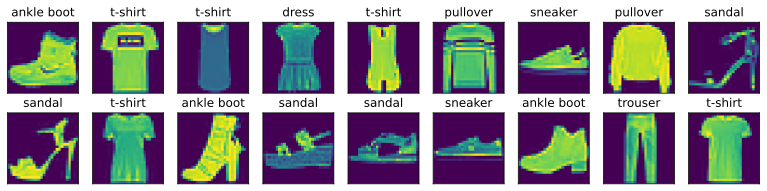

In [ ]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))

show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [ ]:
batch_size = 256

def get_dataloader_workers():
  return 1

train_iter = data.DataLoader(mnist_train, batch_size, shuffle = True, num_workers=get_dataloader_workers())
timer = d2l.Timer()
for X, y in train_iter:
  continue
f"{timer.stop():.2f} sec"

'8.20 sec'

## 从零实现softmax

In [ ]:
#!pip install d2l

In [ ]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

100%|██████████| 26421880/26421880 [00:01<00:00, 14970806.75it/s]


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 271022.36it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4999084.99it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19347918.45it/s]


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad = True)
b = torch.zeros(num_outputs, requires_grad=True)

In [ ]:
X = torch.tensor([[1.0,2.0,3.0], [4.0,5.0,6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [ ]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdim=True)
  return X_exp / partition

In [ ]:
X = torch.normal(0,1,(2,5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0867, 0.5709, 0.1210, 0.0479, 0.1736],
         [0.2153, 0.1248, 0.5264, 0.0929, 0.0406]]),
 tensor([1., 1.]))

In [ ]:
#定义模型
def net(X):
  return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [ ]:
y = torch.tensor([0,2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0,1], y], y_hat

(tensor([0.1000, 0.5000]),
 tensor([[0.1000, 0.3000, 0.6000],
         [0.3000, 0.2000, 0.5000]]))

In [ ]:
#交叉熵损失函数
def cross_entropy(y_hat, y):
  return -torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [ ]:
#预测类别与真实y进行比较
def accuracy(y_hat, y):
  """计算预测正确的数量"""
  if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
    y_hat = y_hat.argmax(axis=1)
  cmp = y_hat.type(y.dtype) == y
  return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

In [ ]:
#评估任意模型的准确率
def evaluate_accuracy(net, data_iter):
  """计算在指定数据集上模型的精度"""
  if isinstance(net, torch.nn.Module):
    net.eval()
  metric = Accumulator(2)
  with torch.no_grad():
    for X, y in data_iter:
      metric.add(accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]

In [ ]:
class Accumulator:
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

evaluate_accuracy(net, test_iter)

0.1473

In [ ]:
#softmax 回归训练
def train_epoch_ch3(net, train_iter, loss, updater):
  if isinstance(net, torch.nn.Module):
    net.train()
  metric = Accumulator(3)
  for X, y in train_iter:
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):
      updater.zero_grad()
      l.mean().backward()
      updater.step()
      metric.add(float(1)* len(y), accuracy(y_hat, y), y.size().numel())
    else:
      l.mean().backward()
      updater(X.shape[0])
      metric.add(float(l.sum()), accuracy(y_hat,y), y.numel())
  return metric[0]/metric[2], metric[1]/metric[2]

In [ ]:
#动画类，绘制数据
class Animator:
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

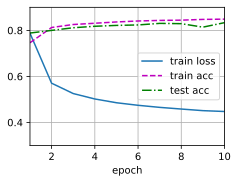

In [ ]:
lr = 0.1
def updater(batch_size):
  return d2l.sgd([W,b], lr, batch_size)

num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [ ]:
def predict_ch3(net, test_iter, n = 30):
  for X, y in test_iter:
    break
  trues = d2l.get_fashion_mnist_labels(y)
  preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis = 1))
  titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
  d2l.show_images(X[0:n].reshape((n, 28,28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## softmax简洁实现

In [ ]:
!pip install d2l

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

loss = nn.CrossEntropyLoss()
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

ModuleNotFoundError: ignored